In [1]:
import bw2data, bw2calc, bw2io
from edges import EdgeLCIA, get_available_methods
from bw2analyzer.contribution import ContributionAnalysis

In [2]:
bw2data.projects.set_current("bw25_ei310")
act = bw2data.Database("ecoinvent-3.10-cutoff").random()
#act = [a for a in bw2data.Database("ecoinvent-3.10-cutoff") if "NMC" in #a["name"]][0]
act

'wheat grain production' (kilogram, RoW, None)

In [3]:
[m for m in get_available_methods() if "ImpactWorld" in str(m)]

[('ImpactWorld+ 2.1', 'Freshwater acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land occupation, biodiversity', 'damage'),
 ('ImpactWorld+ 2.1', 'Land occupation, biodiversity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land transformation, biodiversity', 'damage'),
 ('ImpactWorld+ 2.1', 'Land transformation, biodiversity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Marine eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Marine eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Terrestrial acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Terrestrial acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Thermally polluted water', 'damage'),
 ('ImpactWorld+ 2.1', 'Thermally polluted water', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Water availability, freshwater ecosystem', 'damage'),
 ('ImpactWorld+ 2.1', 'Water 

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|███████████████████████████████████| 19812/19812 [00:05<00:00, 3955.35it/s]


Handling static regions...


100%|████████████████████████████████████| 6350/6350 [00:00<00:00, 35487.31it/s]


Handling dynamic regions...


100%|██████████████████████████████████████| 6350/6350 [00:09<00:00, 687.48it/s]


Handling unmatched locations...


100%|████████████████████████████████████| 2657/2657 [00:00<00:00, 50708.07it/s]


Handling remaining exchanges...


100%|██████████████████████████████████████| 2657/2657 [00:10<00:00, 260.96it/s]


+---------------------------+----------------------------------+
|          Activity         |      wheat grain production      |
|        Method name        | ('ImpactWorld+ 2.1', 'Freshwater |
|                           |   acidification', 'midpoint')    |
|         Data file         |   ImpactWorld+ 2.1_Freshwater    |
|                           |      acidification_midpoint      |
|    Unique CFs in method   |               4598               |
|      Unique CFs used      |               734                |
| CFs without eligible exc. |              18818               |
|     Exc. characterized    |              10543               |
|    Exc. uncharacterized   |                0                 |
+---------------------------+----------------------------------+
Matrix type: biosphere


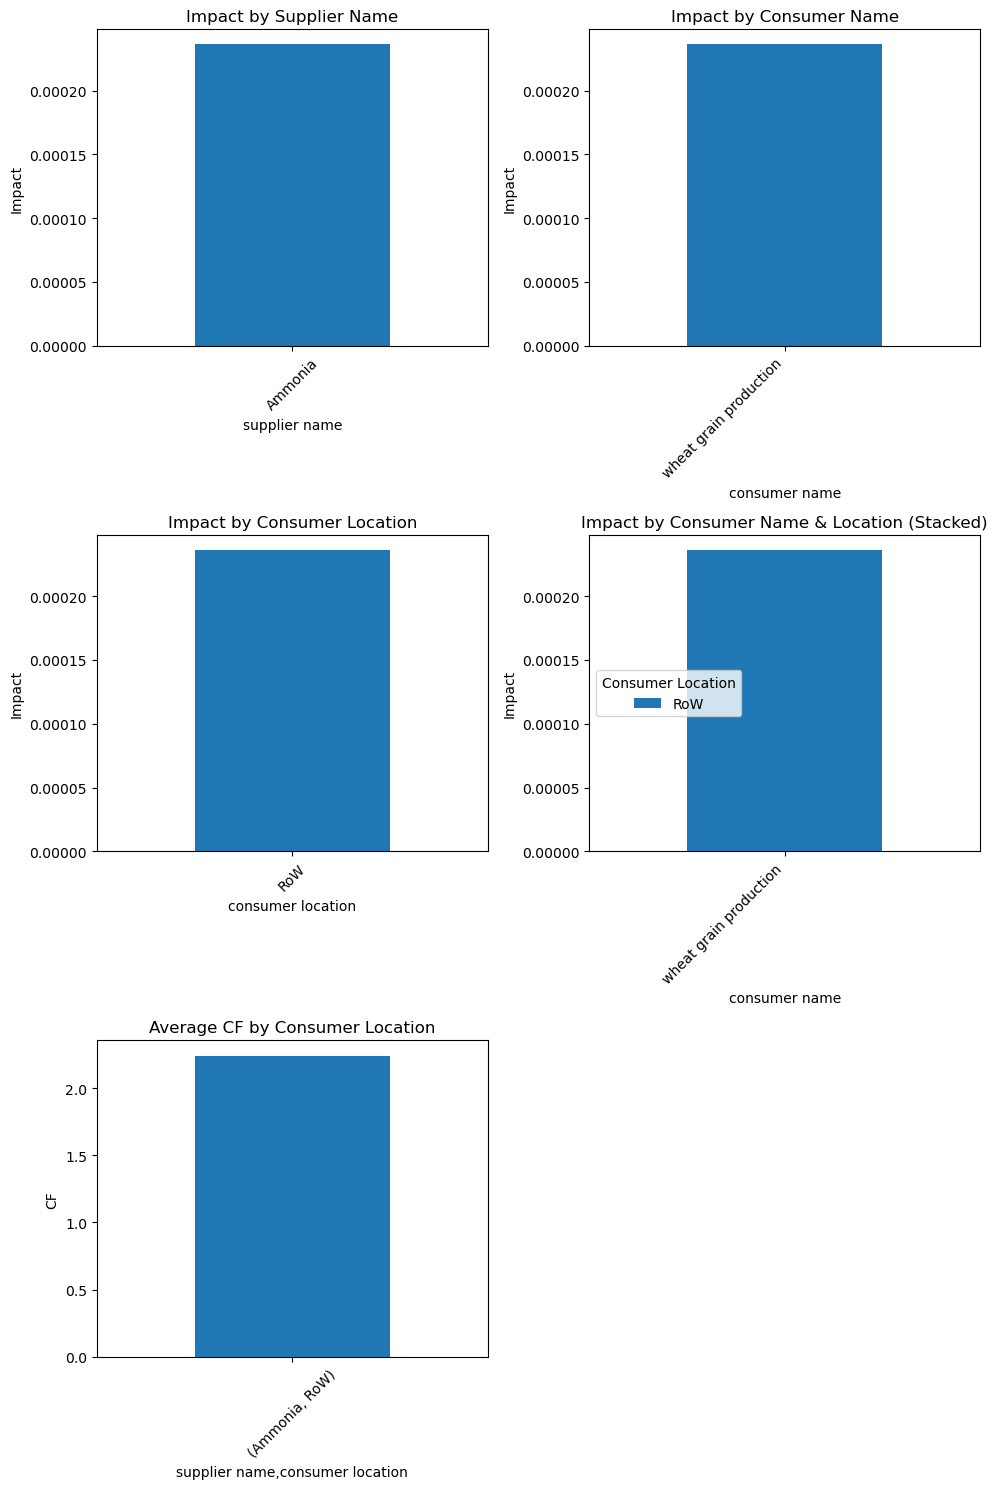

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████| 3990/3990 [00:00<00:00, 4207.57it/s]


Handling static regions...


100%|████████████████████████████████████| 2723/2723 [00:00<00:00, 36154.36it/s]


Handling dynamic regions...


100%|█████████████████████████████████████| 2723/2723 [00:01<00:00, 2055.11it/s]


Handling unmatched locations...


100%|██████████████████████████████████████| 383/383 [00:00<00:00, 28264.10it/s]


Handling remaining exchanges...


100%|███████████████████████████████████████| 383/383 [00:00<00:00, 1169.02it/s]


+---------------------------+----------------------------------+
|          Activity         |      wheat grain production      |
|        Method name        | ('ImpactWorld+ 2.1', 'Freshwater |
|                           |   eutrophication', 'midpoint')   |
|         Data file         |   ImpactWorld+ 2.1_Freshwater    |
|                           |     eutrophication_midpoint      |
|    Unique CFs in method   |               1352               |
|      Unique CFs used      |               329                |
| CFs without eligible exc. |               3182               |
|     Exc. characterized    |               5242               |
|    Exc. uncharacterized   |                0                 |
+---------------------------+----------------------------------+
Matrix type: biosphere


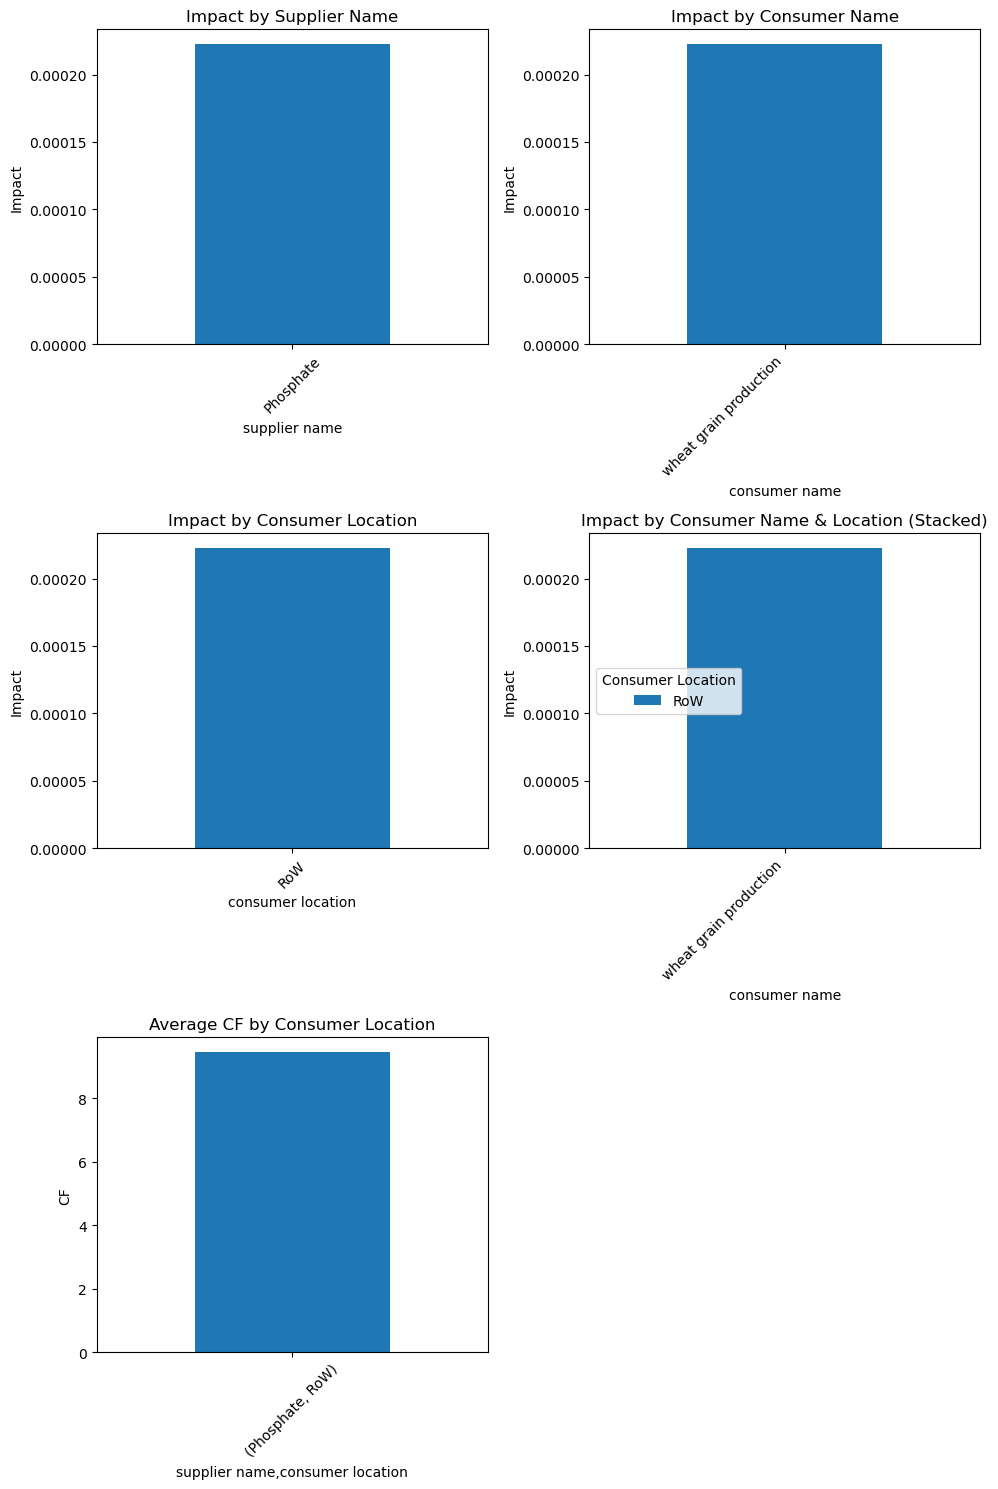

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████| 1838/1838 [00:00<00:00, 4356.46it/s]


Handling static regions...


100%|██████████████████████████████████████| 413/413 [00:00<00:00, 49560.76it/s]


Handling dynamic regions...


100%|███████████████████████████████████████| 413/413 [00:00<00:00, 4200.52it/s]


Handling unmatched locations...


100%|██████████████████████████████████████| 138/138 [00:00<00:00, 19835.98it/s]


Handling remaining exchanges...


100%|███████████████████████████████████████| 138/138 [00:00<00:00, 2251.81it/s]


+---------------------------+----------------------------------------+
|          Activity         |         wheat grain production         |
|        Method name        | ('ImpactWorld+ 2.1', 'Land occupation, |
|                           |       biodiversity', 'midpoint')       |
|         Data file         |   ImpactWorld+ 2.1_Land occupation,    |
|                           |         biodiversity_midpoint          |
|    Unique CFs in method   |                  1126                  |
|      Unique CFs used      |                  155                   |
| CFs without eligible exc. |                  1646                  |
|     Exc. characterized    |                  744                   |
|    Exc. uncharacterized   |                   0                    |
+---------------------------+----------------------------------------+
Matrix type: biosphere


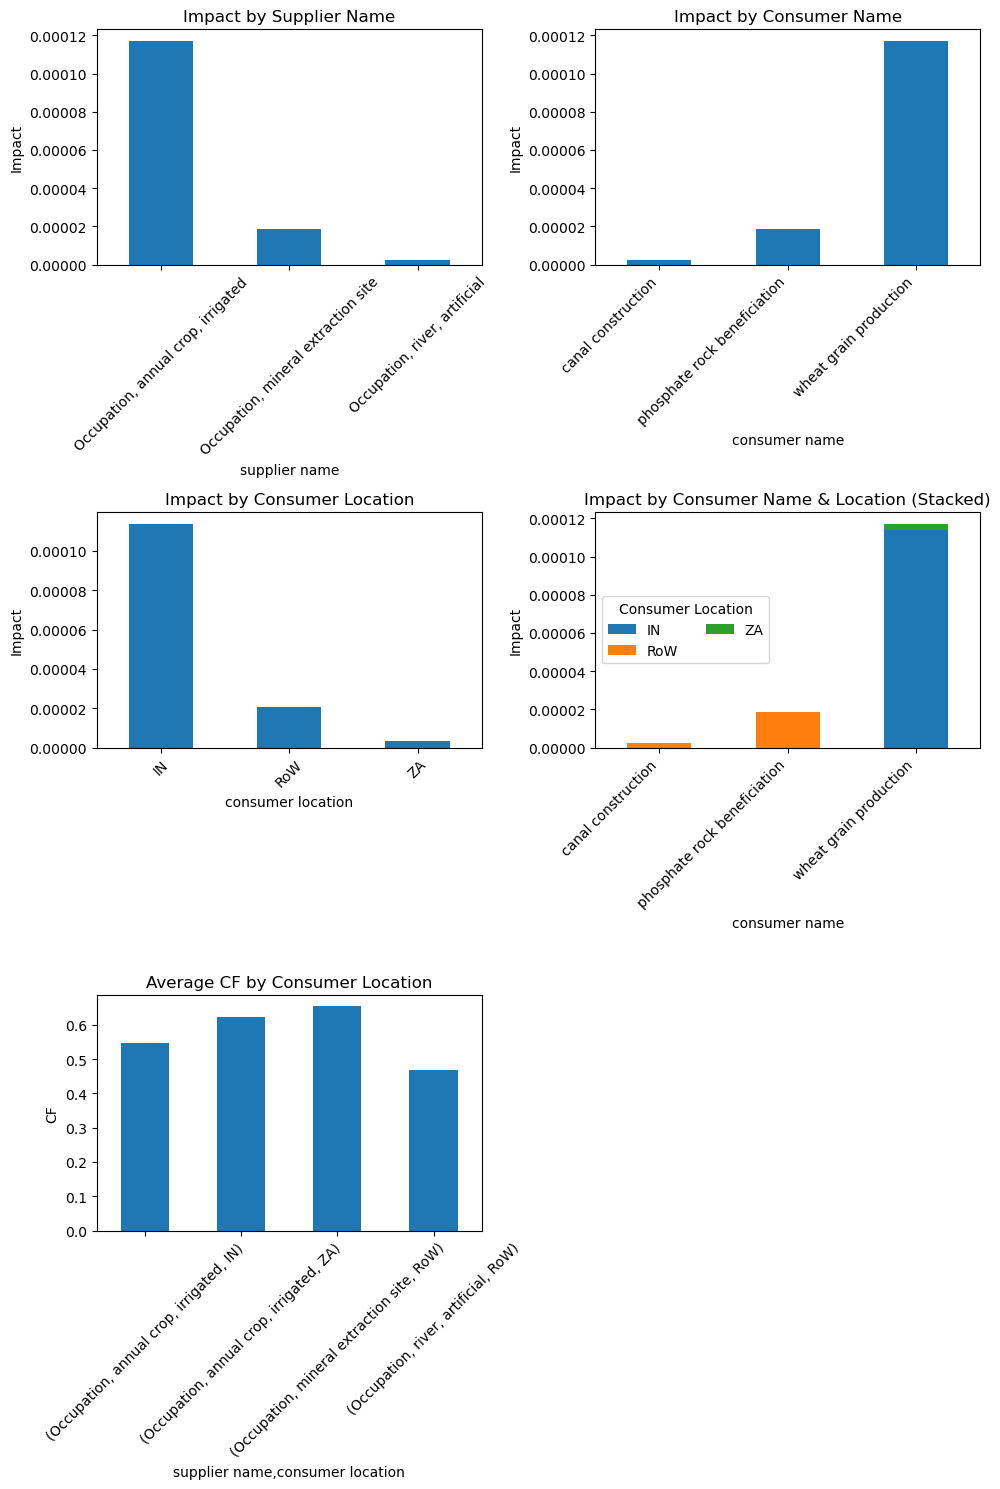

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████| 3676/3676 [00:00<00:00, 4290.47it/s]


Handling static regions...


100%|████████████████████████████████████| 1255/1255 [00:00<00:00, 39189.47it/s]


Handling dynamic regions...


100%|█████████████████████████████████████| 1255/1255 [00:00<00:00, 2210.71it/s]


Handling unmatched locations...


100%|██████████████████████████████████████| 311/311 [00:00<00:00, 18489.94it/s]


Handling remaining exchanges...


100%|███████████████████████████████████████| 311/311 [00:00<00:00, 1337.17it/s]


+---------------------------+--------------------------------------------+
|          Activity         |           wheat grain production           |
|        Method name        | ('ImpactWorld+ 2.1', 'Land transformation, |
|                           |         biodiversity', 'midpoint')         |
|         Data file         |   ImpactWorld+ 2.1_Land transformation,    |
|                           |           biodiversity_midpoint            |
|    Unique CFs in method   |                    2258                    |
|      Unique CFs used      |                    429                     |
| CFs without eligible exc. |                    3148                    |
|     Exc. characterized    |                    2417                    |
|    Exc. uncharacterized   |                     0                      |
+---------------------------+--------------------------------------------+
Matrix type: biosphere


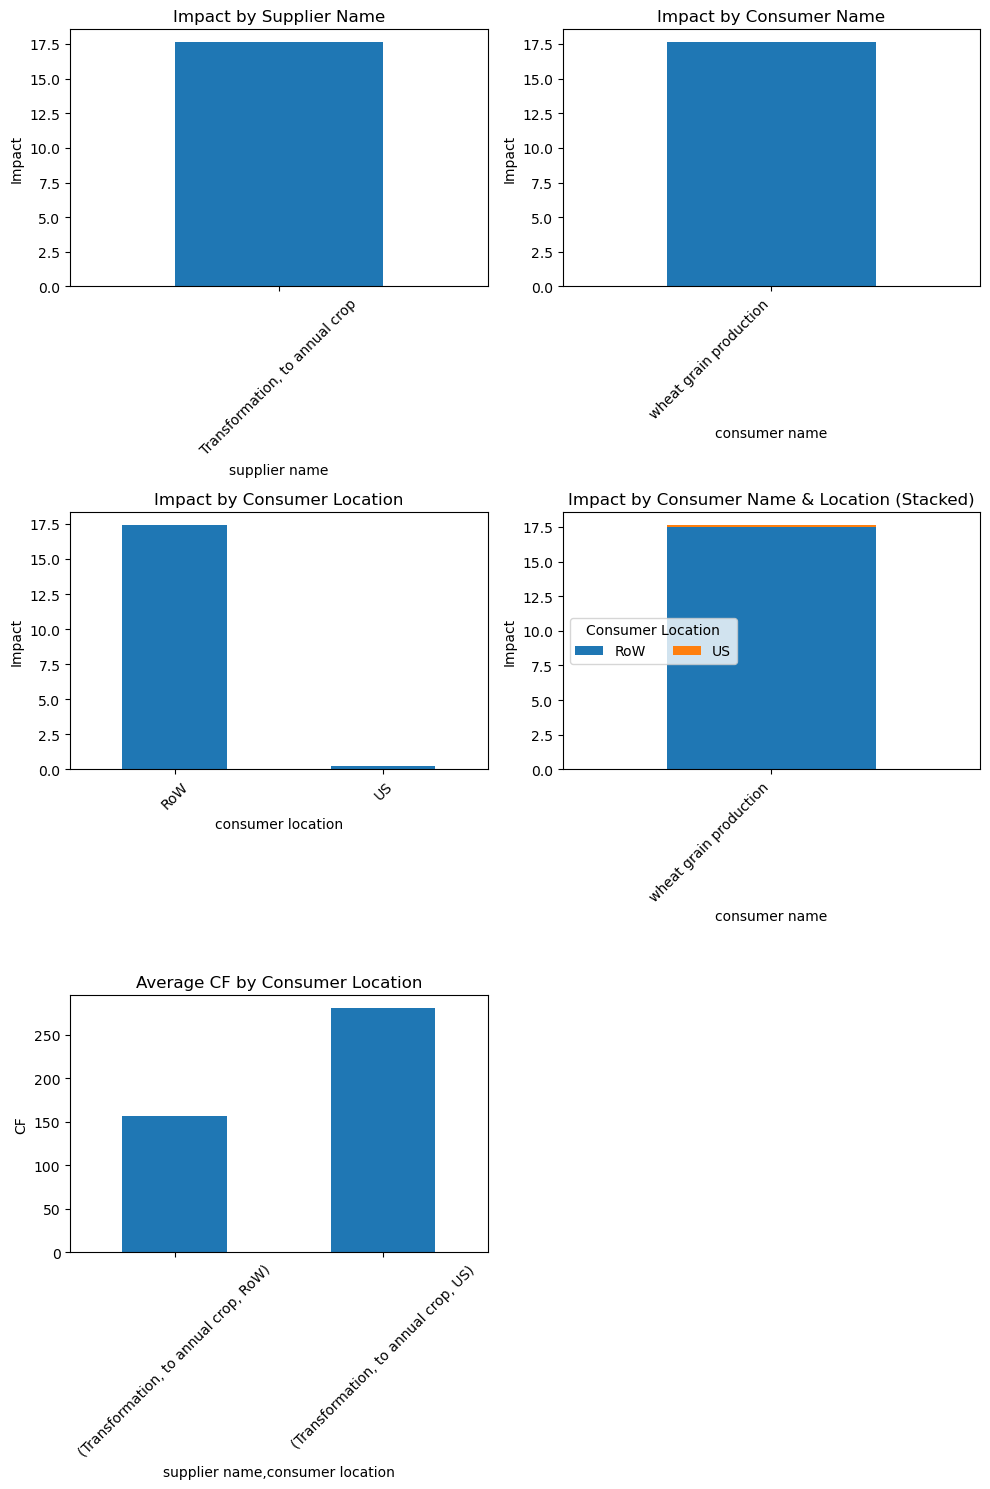

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|███████████████████████████████████| 18288/18288 [00:04<00:00, 4283.48it/s]


Handling static regions...


100%|████████████████████████████████████| 6329/6329 [00:00<00:00, 33762.27it/s]


Handling dynamic regions...


100%|██████████████████████████████████████| 6329/6329 [00:08<00:00, 773.79it/s]


Handling unmatched locations...


100%|████████████████████████████████████| 2893/2893 [00:00<00:00, 39783.87it/s]


Handling remaining exchanges...


100%|██████████████████████████████████████| 2893/2893 [00:10<00:00, 282.76it/s]


+---------------------------+-----------------------------------------------+
|          Activity         |             wheat grain production            |
|        Method name        | ('ImpactWorld+ 2.1', 'Marine eutrophication', |
|                           |                  'midpoint')                  |
|         Data file         |            ImpactWorld+ 2.1_Marine            |
|                           |            eutrophication_midpoint            |
|    Unique CFs in method   |                      3830                     |
|      Unique CFs used      |                      849                      |
| CFs without eligible exc. |                     17142                     |
|     Exc. characterized    |                     10377                     |
|    Exc. uncharacterized   |                       0                       |
+---------------------------+-----------------------------------------------+
Matrix type: biosphere


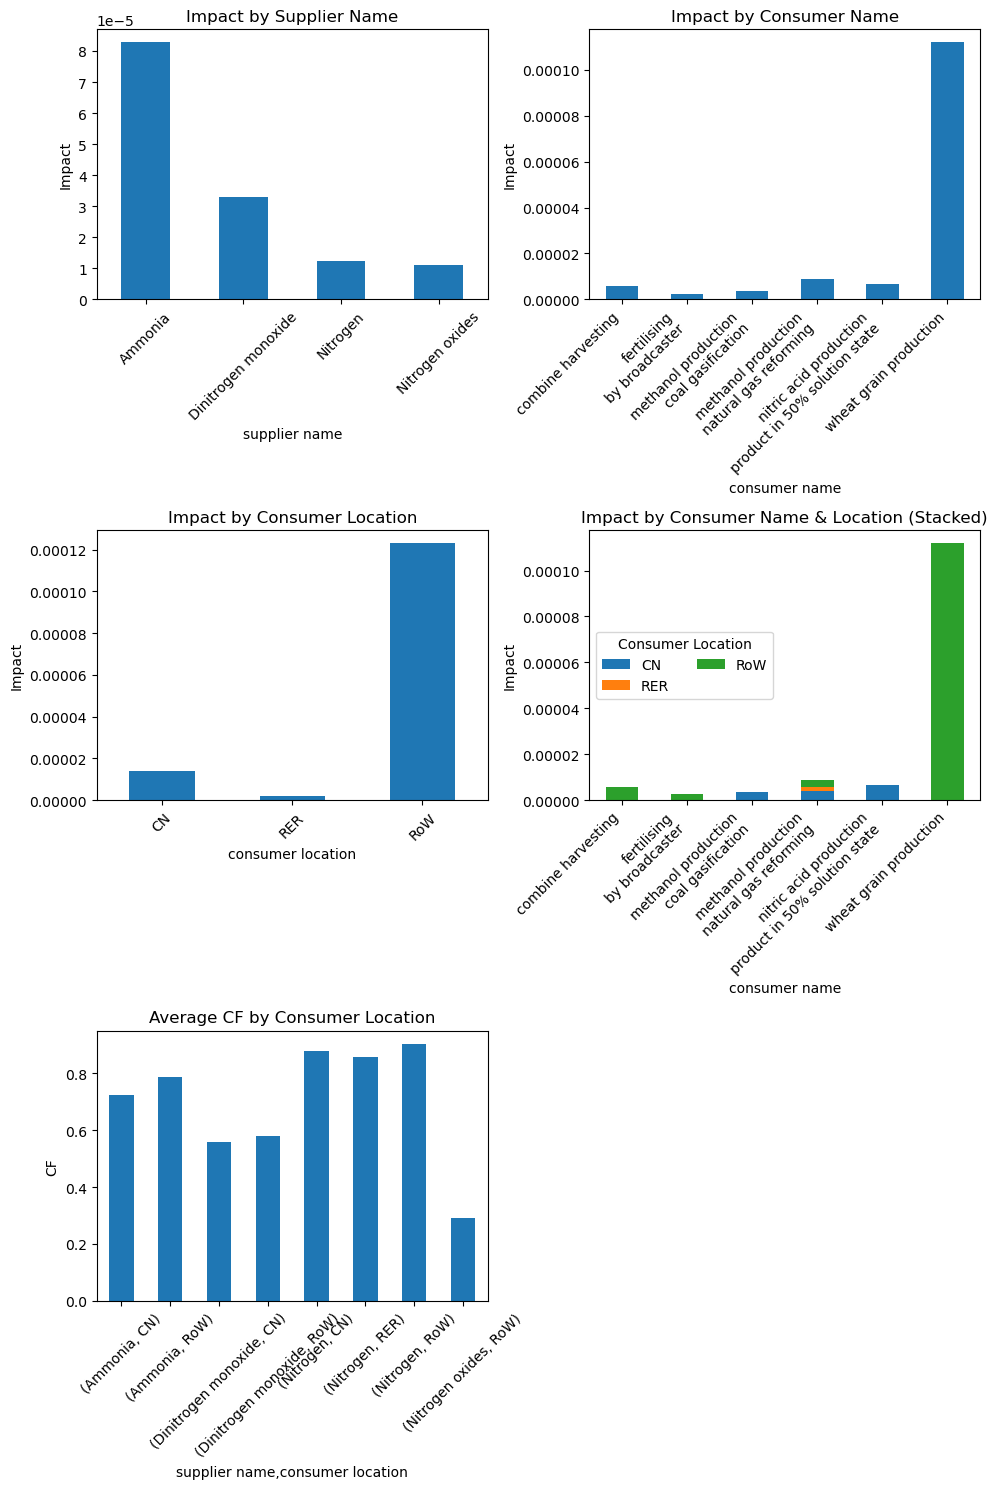

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|███████████████████████████████████| 18288/18288 [00:04<00:00, 4398.32it/s]


Handling static regions...


100%|████████████████████████████████████| 6350/6350 [00:00<00:00, 36740.73it/s]


Handling dynamic regions...


100%|██████████████████████████████████████| 6350/6350 [00:08<00:00, 739.53it/s]


Handling unmatched locations...


100%|████████████████████████████████████| 2657/2657 [00:00<00:00, 16263.80it/s]


Handling remaining exchanges...


100%|██████████████████████████████████████| 2657/2657 [00:09<00:00, 282.79it/s]


+---------------------------+-----------------------------------+
|          Activity         |       wheat grain production      |
|        Method name        | ('ImpactWorld+ 2.1', 'Terrestrial |
|                           |    acidification', 'midpoint')    |
|         Data file         |    ImpactWorld+ 2.1_Terrestrial   |
|                           |       acidification_midpoint      |
|    Unique CFs in method   |                4214               |
|      Unique CFs used      |                733                |
| CFs without eligible exc. |               17294               |
|     Exc. characterized    |               10543               |
|    Exc. uncharacterized   |                 0                 |
+---------------------------+-----------------------------------+
Matrix type: biosphere


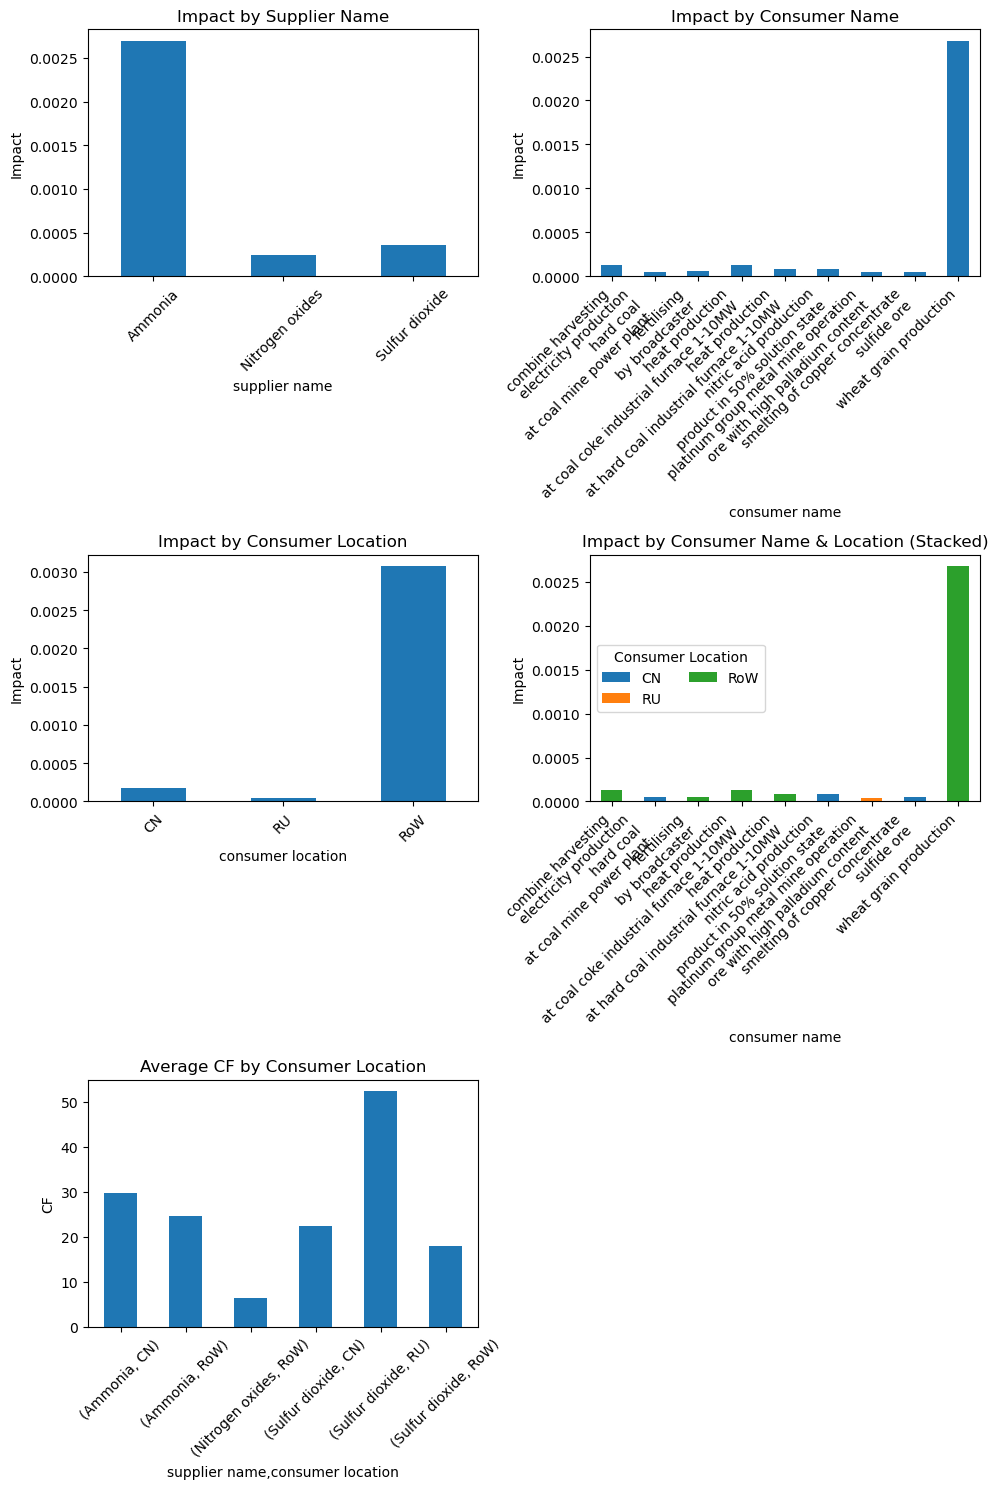

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 4423.20it/s]


Handling static regions...


100%|██████████████████████████████████████| 232/232 [00:00<00:00, 55200.73it/s]


Handling dynamic regions...


100%|██████████████████████████████████████| 232/232 [00:00<00:00, 72911.62it/s]


Handling unmatched locations...


100%|██████████████████████████████████████| 209/209 [00:00<00:00, 25177.63it/s]


Handling remaining exchanges...


100%|██████████████████████████████████████| 209/209 [00:00<00:00, 11573.78it/s]

+---------------------------+------------------------------------------+
|          Activity         |          wheat grain production          |
|        Method name        | ('ImpactWorld+ 2.1', 'Thermally polluted |
|                           |           water', 'midpoint')            |
|         Data file         |   ImpactWorld+ 2.1_Thermally polluted    |
|                           |              water_midpoint              |
|    Unique CFs in method   |                    1                     |
|      Unique CFs used      |                    3                     |
| CFs without eligible exc. |                    39                    |
|     Exc. characterized    |                   304                    |
|    Exc. uncharacterized   |                    0                     |
+---------------------------+------------------------------------------+
Matrix type: biosphere


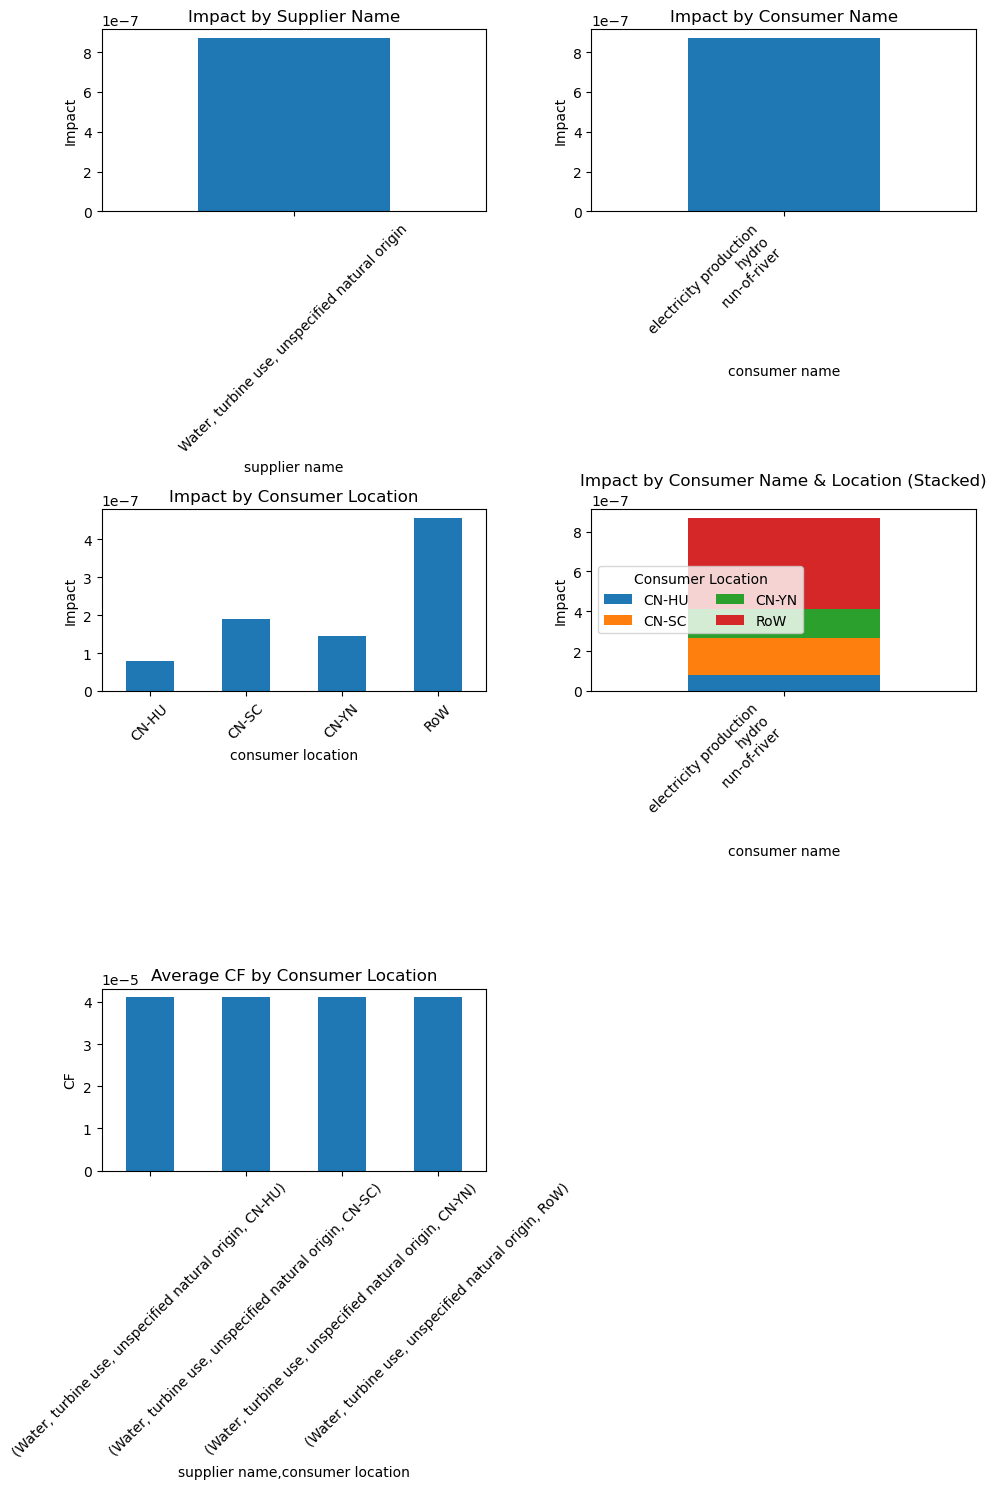

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████| 2440/2440 [00:00<00:00, 4386.42it/s]


Handling static regions...


100%|████████████████████████████████████| 3552/3552 [00:00<00:00, 70978.81it/s]


Handling dynamic regions...


100%|█████████████████████████████████████| 3552/3552 [00:00<00:00, 3606.31it/s]


Handling unmatched locations...


100%|██████████████████████████████████████| 996/996 [00:00<00:00, 51771.90it/s]


Handling remaining exchanges...


100%|███████████████████████████████████████| 996/996 [00:00<00:00, 1824.12it/s]


+---------------------------+-------------------------------------------+
|          Activity         |           wheat grain production          |
|        Method name        | ('ImpactWorld+ 2.1', 'Water availability, |
|                           |     freshwater ecosystem', 'midpoint')    |
|         Data file         |    ImpactWorld+ 2.1_Water availability,   |
|                           |       freshwater ecosystem_midpoint       |
|    Unique CFs in method   |                     2                     |
|      Unique CFs used      |                     26                    |
| CFs without eligible exc. |                    2051                   |
|     Exc. characterized    |                    6801                   |
|    Exc. uncharacterized   |                     0                     |
+---------------------------+-------------------------------------------+
Matrix type: biosphere


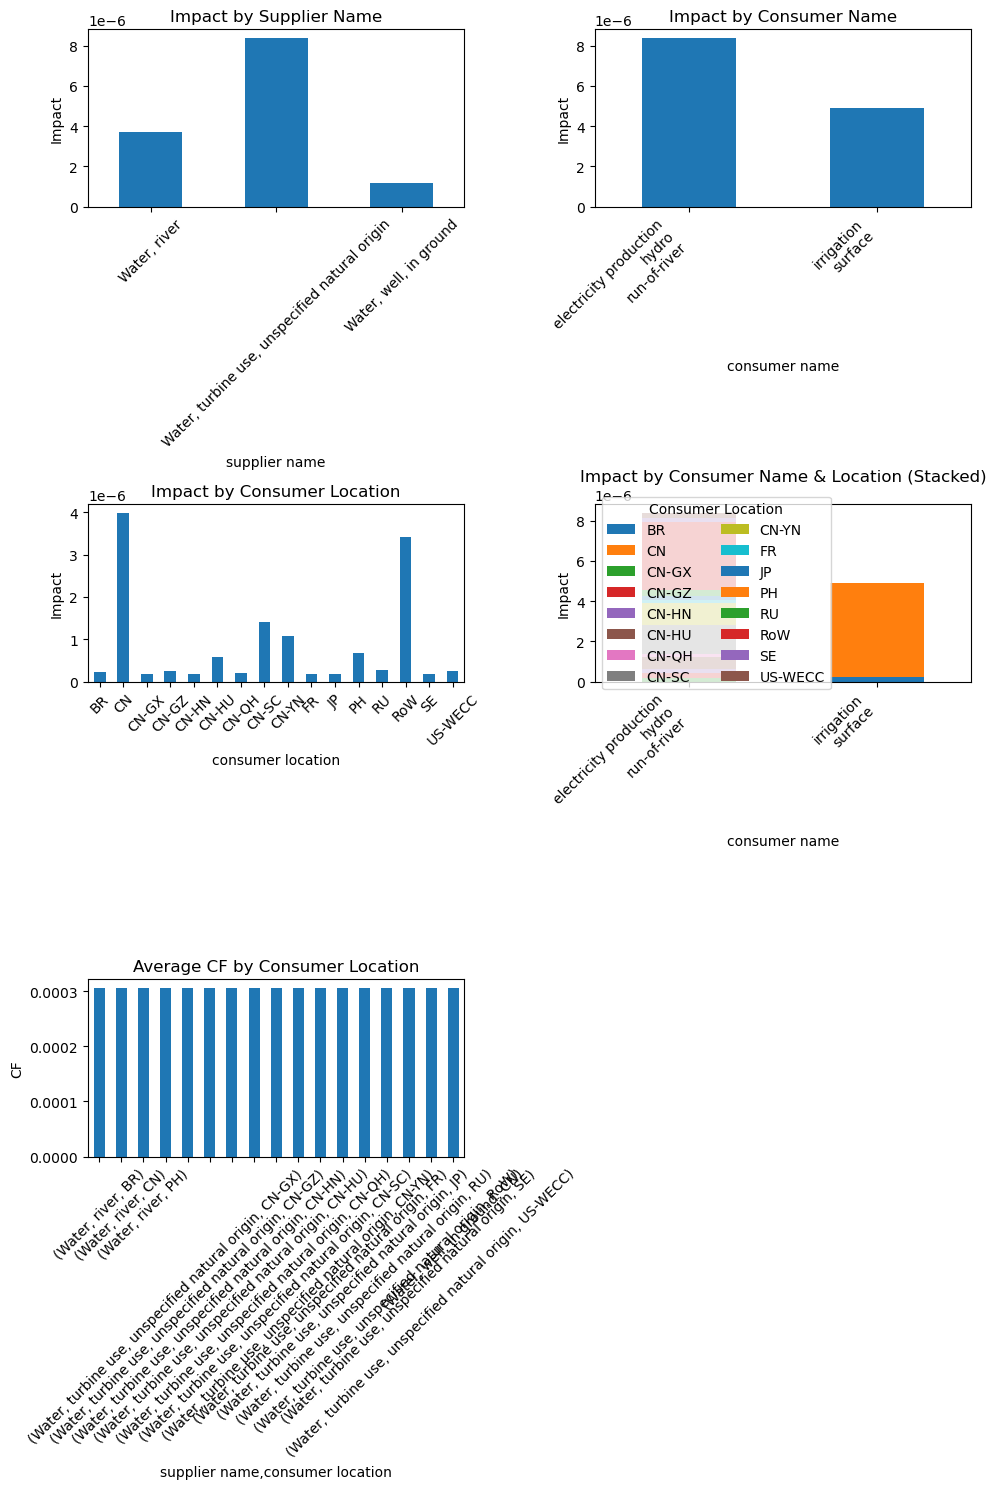

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████| 1080/1080 [00:00<00:00, 4359.60it/s]


Handling static regions...


100%|████████████████████████████████████| 4855/4855 [00:00<00:00, 64948.84it/s]


Handling dynamic regions...


100%|████████████████████████████████████| 4855/4855 [00:00<00:00, 10136.35it/s]


Handling unmatched locations...


100%|████████████████████████████████████| 2329/2329 [00:00<00:00, 57414.01it/s]


Handling remaining exchanges...


100%|█████████████████████████████████████| 2329/2329 [00:00<00:00, 3782.72it/s]


+---------------------------+--------------------------------------------+
|          Activity         |           wheat grain production           |
|        Method name        | ('ImpactWorld+ 2.1', 'Water availability,  |
|                           |         human health', 'midpoint')         |
|         Data file         | ImpactWorld+ 2.1_Water availability, human |
|                           |              health_midpoint               |
|    Unique CFs in method   |                    340                     |
|      Unique CFs used      |                    298                     |
| CFs without eligible exc. |                    901                     |
|     Exc. characterized    |                    6777                    |
|    Exc. uncharacterized   |                     0                      |
+---------------------------+--------------------------------------------+
Matrix type: biosphere


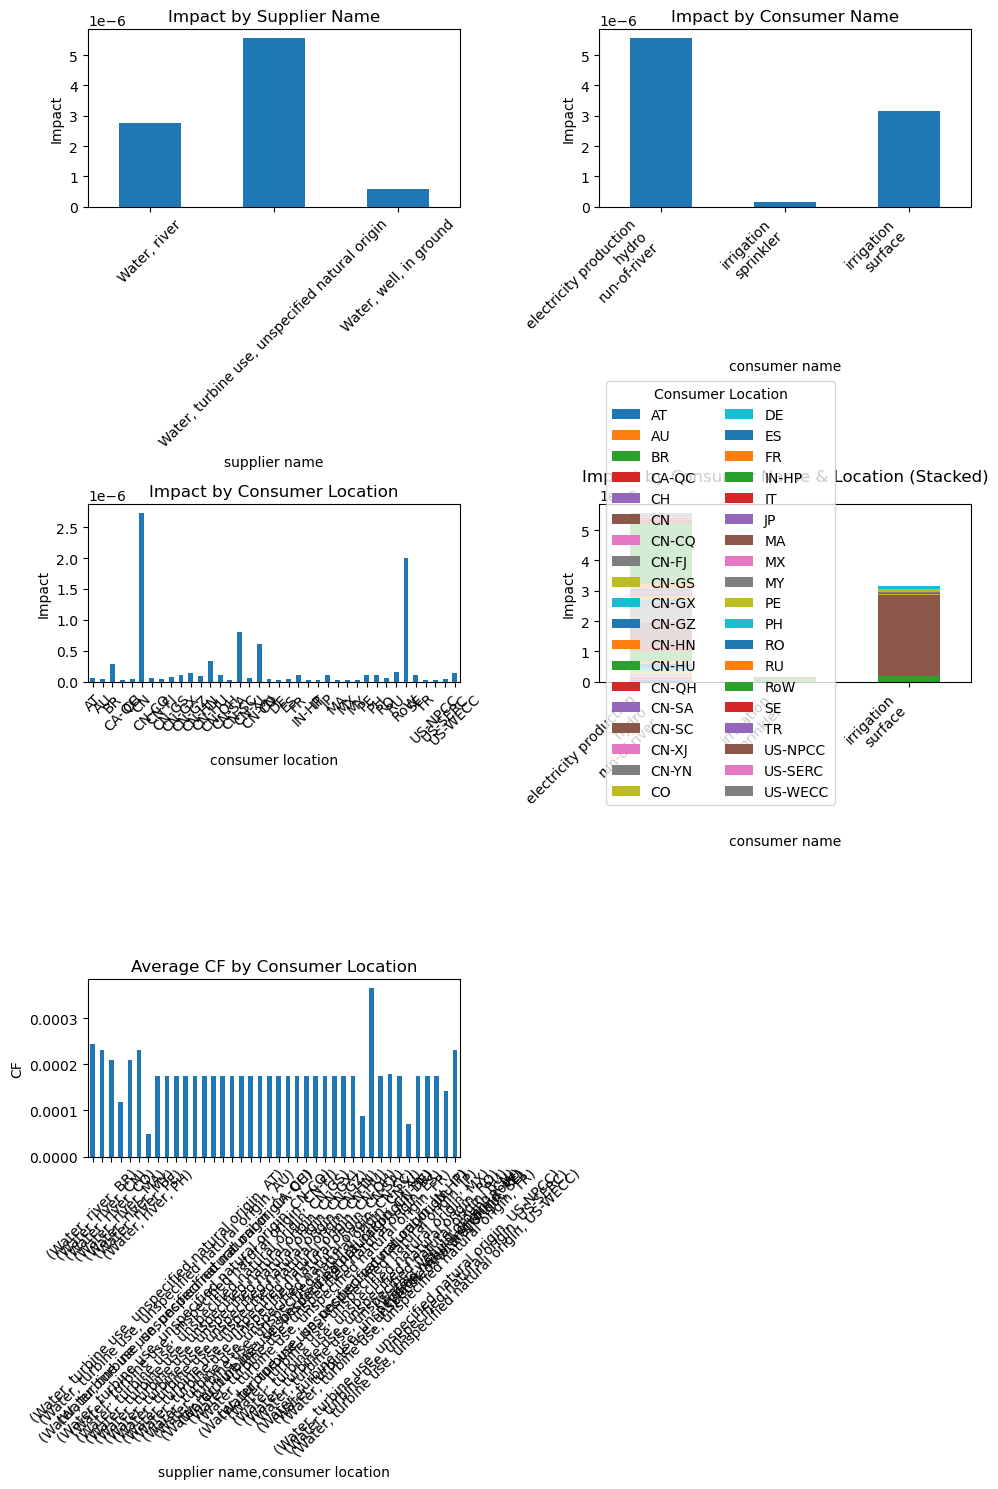

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|███████████████████████████████████████| 107/107 [00:00<00:00, 4583.80it/s]


Handling static regions...


100%|██████████████████████████████████████| 388/388 [00:00<00:00, 86641.64it/s]


Handling dynamic regions...


100%|██████████████████████████████████████| 388/388 [00:00<00:00, 12195.12it/s]


Handling unmatched locations...


100%|████████████████████████████████████████| 30/30 [00:00<00:00, 38164.73it/s]


Handling remaining exchanges...


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 8110.68it/s]

+---------------------------+-------------------------------------------+
|          Activity         |           wheat grain production          |
|        Method name        | ('ImpactWorld+ 2.1', 'Water availability, |
|                           |    terrestrial ecosystem', 'midpoint')    |
|         Data file         |    ImpactWorld+ 2.1_Water availability,   |
|                           |       terrestrial ecosystem_midpoint      |
|    Unique CFs in method   |                    116                    |
|      Unique CFs used      |                     67                    |
| CFs without eligible exc. |                     70                    |
|     Exc. characterized    |                    758                    |
|    Exc. uncharacterized   |                     0                     |
+---------------------------+-------------------------------------------+
Matrix type: biosphere


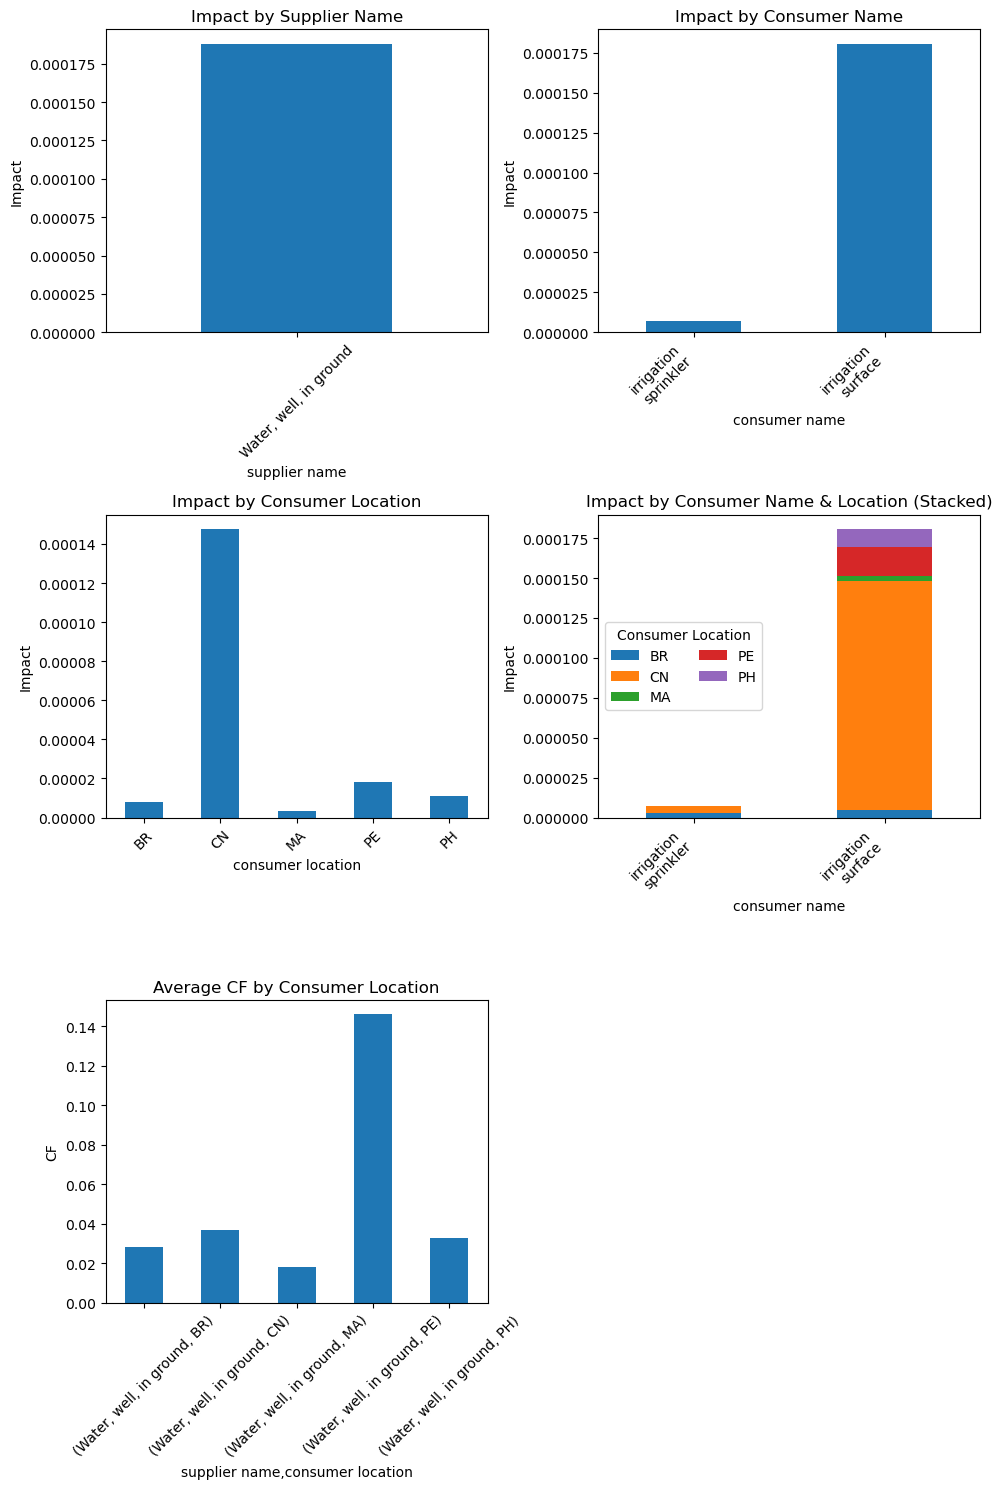

/Users/romain/anaconda3/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)


Identifying eligible exchanges...


100%|█████████████████████████████████████| 3358/3358 [00:00<00:00, 4355.89it/s]


Handling static regions...


100%|████████████████████████████████████| 3493/3493 [00:00<00:00, 71560.75it/s]


Handling dynamic regions...


100%|█████████████████████████████████████| 3493/3493 [00:01<00:00, 2588.21it/s]


Handling unmatched locations...


100%|██████████████████████████████████████| 935/935 [00:00<00:00, 51823.96it/s]


Handling remaining exchanges...


100%|███████████████████████████████████████| 935/935 [00:00<00:00, 1315.71it/s]


+---------------------------+------------------------------------------+
|          Activity         |          wheat grain production          |
|        Method name        |  ('ImpactWorld+ 2.1', 'Water scarcity',  |
|                           |               'midpoint')                |
|         Data file         | ImpactWorld+ 2.1_Water scarcity_midpoint |
|    Unique CFs in method   |                   422                    |
|      Unique CFs used      |                   384                    |
| CFs without eligible exc. |                   2939                   |
|     Exc. characterized    |                   6801                   |
|    Exc. uncharacterized   |                    0                     |
+---------------------------+------------------------------------------+
Matrix type: biosphere


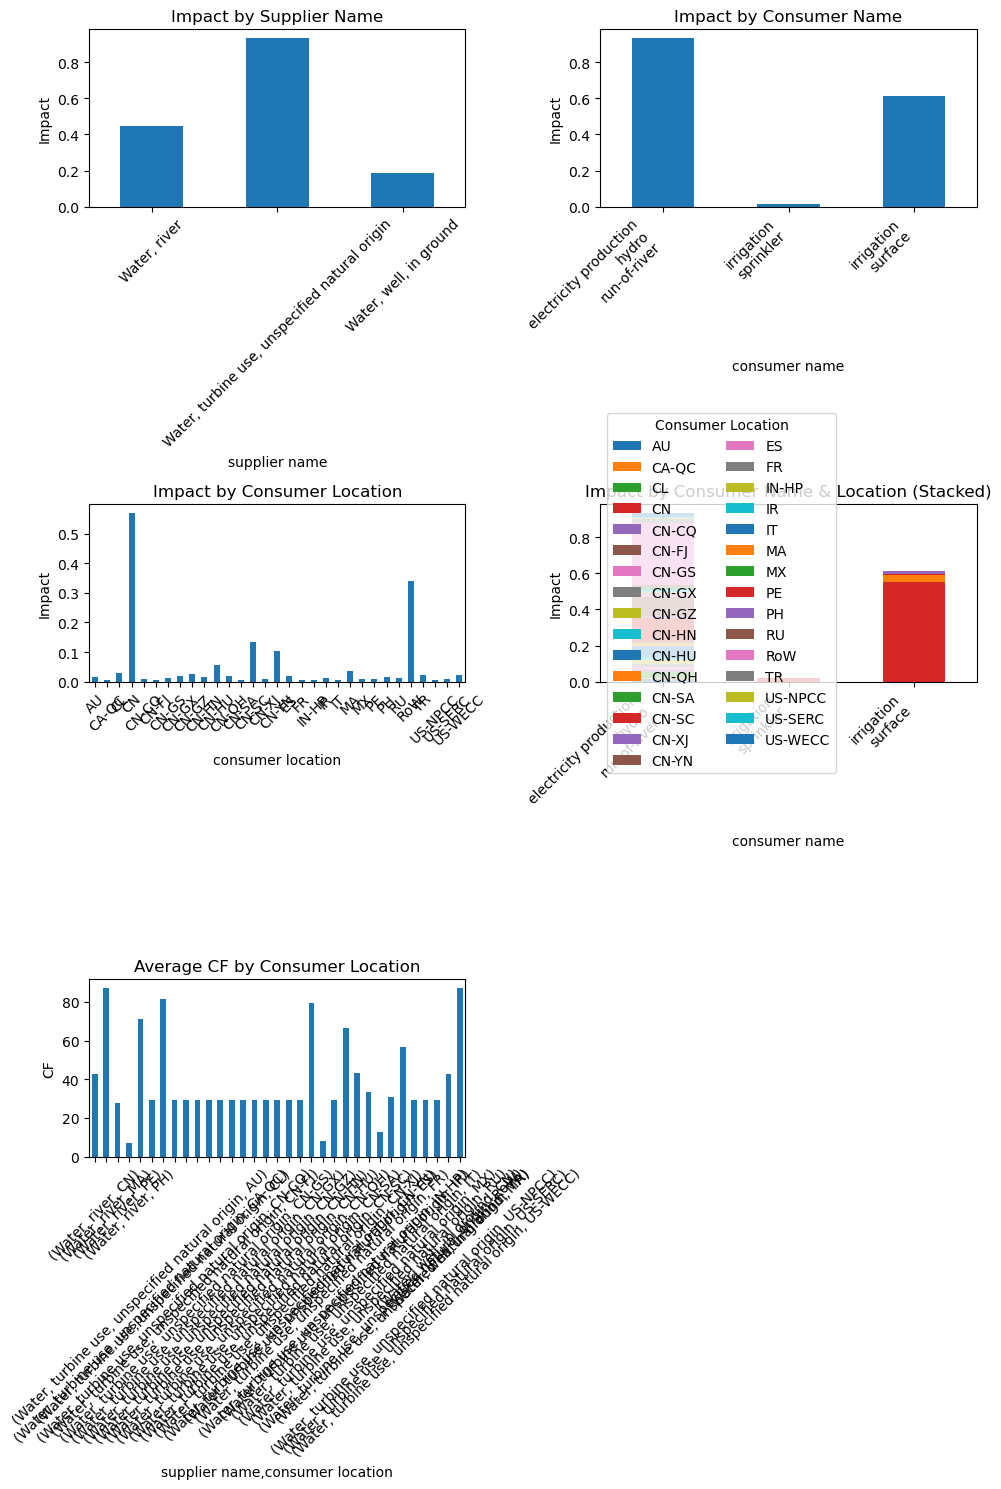

In [4]:
import matplotlib.pyplot as plt
#method = ('GeoPolRisk', '2024')
# method = ('ImpactWorld+ 2.1', 'Land transformation, biodiversity', 'midpoint')
methods = [m for m in get_available_methods() if "ImpactWorld+" in str(m) and "midpoint" in str(m)]
for method in methods:
    LCA = EdgeLCIA({act: 1}, method)
    LCA.lci()
    LCA.lcia()
    df = LCA.generate_cf_table()

    if "water" in str(method):
        cutoff = 0.05
    else:
        cutoff = 0.01

    # remove rows for which "amount" is below the cutoff
    total = df["impact"].sum()
    df = df[df["impact"] > cutoff * total]

    # Plotting
    fig, axes = plt.subplots(3, 2, figsize=(10, 15))

    # 1. Bar plot of "amount" by "supplier name"
    df.groupby("supplier name")["impact"].sum().plot(kind="bar", ax=axes[0, 0])
    axes[0, 0].set_title("Impact by Supplier Name")
    axes[0, 0].set_ylabel("Impact")
    axes[0, 0].tick_params(axis="x", rotation=45)

    # 2. Bar plot of "amount" by "consumer name"
    df.groupby("consumer name")["impact"].sum().plot(kind="bar", ax=axes[0, 1])
    axes[0, 1].set_title("Impact by Consumer Name")
    axes[0, 1].set_ylabel("Impact")
    axes[0, 1].set_xticklabels(
        [label.get_text().replace(", ", "\n") for label in axes[0, 1].get_xticklabels()],
        rotation=45,
        ha="right",
    )

    # 3. Bar plot of "amount" by "consumer location"
    df.groupby("consumer location")["impact"].sum().plot(kind="bar", ax=axes[1, 0])
    axes[1, 0].set_title("Impact by Consumer Location")
    axes[1, 0].set_ylabel("Impact")
    axes[1, 0].tick_params(axis="x", rotation=45)

    # 4. Stacked bar plot for "amount" by "consumer name" and "consumer location"
    df_grouped = df.groupby(["consumer name", "consumer location"])["impact"].sum().unstack()
    df_grouped.plot(kind="bar", stacked=True, ax=axes[1, 1])
    axes[1, 1].set_title("Impact by Consumer Name & Location (Stacked)")
    axes[1, 1].set_ylabel("Impact")
    axes[1, 1].set_xticklabels(
        [label.get_text().replace(", ", "\n") for label in axes[1, 1].get_xticklabels()],
        rotation=45,
        ha="right",
    )
    axes[1, 1].legend(title="Consumer Location", loc="center left", ncol=2)

    # 5. Bar plot of average "CF" by "consumer location"
    df.groupby(["supplier name", "consumer location"])["CF"].mean().plot(kind="bar", ax=axes[2, 0])
    axes[2, 0].set_title("Average CF by Consumer Location")
    axes[2, 0].set_ylabel("CF")
    axes[2, 0].tick_params(axis="x", rotation=45)

    # remove last subplot
    fig.delaxes(axes[2, 1])

    plt.tight_layout()
    plt.show()

    

  #LCA.score

In [16]:
df.groupby(["supplier name", "consumer location"])["CF"].mean()

supplier name   consumer location         
Sulfur dioxide  Europe without Switzerland     4.368280
                GLO                            2.481095
                RU                            24.675845
Name: CF, dtype: float64

In [21]:
list(LCA.demand.keys())[0]

124526838126026753

In [1]:
from constructive_geometries import geomatcher
geo = geomatcher.Geomatcher()

geo.within("PG", biggest_first=False)

['PG', ('ecoinvent', 'UN-MELANESIA'), ('ecoinvent', 'UN-OCEANIA'), 'GLO']

In [2]:
geo.contained("PG", biggest_first=False)

['PG']

In [6]:
set([x["supplier"]["name"] for x in LCA.ignored_method_exchanges])

{'Water',
 'Water, cooling, unspecified natural origin',
 'Water, in air',
 'Water, lake',
 'Water, river',
 'Water, turbine use, unspecified natural origin',
 'Water, unspecified natural origin',
 'Water, well, in ground'}

In [7]:
LCA.generate_cf_table()

Matrix type: biosphere


,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
0,"Water, cooling, unspecified natural origin","(natural resource, in water)","particleboard production, uncoated, from virgi...","particleboard, uncoated",RoW,6.544631e-11,20.179399,1.320667e-09
1,"Water, cooling, unspecified natural origin","(natural resource, in water)","heat and power co-generation, lignite","electricity, high voltage",SI,1.453419e-07,1.087201,1.580158e-07
2,"Water, cooling, unspecified natural origin","(natural resource, in water)",atrazine production,atrazine,RoW,4.228744e-12,19.819034,8.380961e-11
3,"Water, cooling, unspecified natural origin","(natural resource, in water)","sheet rolling, copper","sheet rolling, copper",RoW,1.290820e-10,19.819034,2.558280e-09
4,"Water, cooling, unspecified natural origin","(natural resource, in water)","phosphoric acid production, dihydrate process","phosphoric acid, fertiliser grade, without wat...",MA,5.123237e-08,54.031045,2.768139e-06
...,...,...,...,...,...,...,...,...
4923,"Water, in air","(natural resource, in air)",soy-based resin production,"polyester resin, unsaturated",US,4.729868e-16,9.087076,4.298067e-15
4924,"Water, in air","(natural resource, in air)",soy-based resin production,"polyester resin, unsaturated",RoW,1.378576e-15,20.175187,2.781303e-14
4925,"Water, in air","(natural resource, in air)",clinker production,clinker,RoW,1.625316e-09,20.627229,3.352577e-08
4926,"Water, in air","(natural resource, in air)","particleboard production, cement bonded","particleboard, cement bonded",RER,8.635607e-19,6.750246,5.829247e-18


In [7]:
LCA.ignored_locations

set()

In [9]:
method = ('AWARE 1.2c', 'Country', 'mixed', 'yearly')
convmethod = (
  # 'ecoinvent-3.10',
  'EF v3.1 EN15804',
  'water use',
  'user deprivation potential (deprivation-weighted water consumption)')

In [10]:
import bw2calc

convLCA = bw2calc.LCA({act: 1}, convmethod)
convLCA.lci()
convLCA.lcia()
convLCA.score

/opt/homebrew/Caskroom/miniforge/base/envs/bw2/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.83e+13)
  warnings.warn(msg, UmfpackWarning)


0.06176615560312869